<a href="https://colab.research.google.com/github/advaitkumar3107/GNR-652-Project/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.1307,), (.3081,))
        ])
    out_dir = './dataset'
    return dsets.MNIST(root=out_dir, train=True, transform=compose, download=True)# Load data
training = mnist_data()# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(training, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_loader)


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


In [0]:
class generator_net(nn.Module):
  def __init__ (self):
    super(generator_net, self).__init__()
    self.hidden0 = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2)
        )
    self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
    self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
    self.output = nn.Sequential(
            nn.Linear(1024, 784),
            nn.Tanh()
        )

  def forward(self,x):
    out = self.hidden0(x)
    out = self.hidden1(out)
    out = self.hidden2(out)
    out = self.output(out)
    return out

class discriminator_net(nn.Module):
  def __init__(self):
    super(discriminator_net, self).__init__()
    self.hidden0 = nn.Sequential(nn.Linear(784,512), nn.LeakyReLU(0.2), nn.Dropout(0.3))
    self.hidden1 = nn.Sequential(nn.Linear(512,256), nn.LeakyReLU(0.2), nn.Dropout(0.3))
    self.hidden2 = nn.Sequential(nn.Linear(256,128), nn.LeakyReLU(0.2), nn.Dropout(0.3))
    self.output = nn.Sequential(nn.Linear(128,1), nn.Sigmoid())

  def forward(self,x):
    out = self.hidden0(x)
    out = self.hidden1(out)
    out = self.hidden2(out)
    out = self.output(out)
    return out

discriminator = discriminator_net()
generator = generator_net()

In [0]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  discriminator.cuda()
  generator.cuda()

In [0]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0003)

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100)).cuda()
    return n

In [0]:
def train_discriminator(noise_sample, example, optimizer):
  n = example.size(0)
  optimizer.zero_grad()
  discriminator.train()
  generator.eval()
  real_prediction = discriminator(example)
  fake_prediction = discriminator(noise_sample)
  
  loss_function = nn.BCELoss()
  one = Variable(torch.ones(n,1)).cuda()
  zero = Variable(torch.zeros(n,1)).cuda()
  real_error = loss_function(real_prediction, one)
  real_error.backward() 
  fake_error = loss_function(fake_prediction, zero)
  fake_error.backward()
  error = fake_error + real_error
  optimizer.step()

  return error, real_prediction, fake_prediction

def train_generator(noise_sample, optimizer):
  optimizer.zero_grad()
  discriminator.eval()
  generator.train()
  n = noise_sample.size(0)
  noise_sample = noise_sample.cuda()
  output = discriminator(noise_sample)
  loss_function = nn.BCELoss()
  one = Variable(torch.ones(n,1)).cuda()
  error = (loss_function(output, one))
  error.backward()
  optimizer.step()

  return error, output


In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

num_epochs = 100

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
for epoch in range(num_epochs):
  for i, (real_batch,_) in enumerate(train_loader):
    for k in range(2):
      n = real_batch.size(0)
      
      real_data = Variable(images_to_vectors(real_batch)).cuda()
      fake_data = generator(noise(n).cuda()).detach().cuda()
      
      d_error, d_real, d_fake = train_discriminator(fake_data, real_data, d_optimizer)
    
    fake_data = generator(noise(n)).cuda()
    
    g_error, g_output = train_generator(fake_data, g_optimizer)
  
  print('Epoch: [%d/%d], Discriminator Error: %f, Generator Error: %f'%(epoch+1, num_epochs, d_error, g_error) )
  


Epoch: [1/100], Discriminator Error: 0.001206, Generator Error: 10.227750
Epoch: [2/100], Discriminator Error: 0.000883, Generator Error: 13.583866
Epoch: [3/100], Discriminator Error: 0.000020, Generator Error: 12.246386
Epoch: [4/100], Discriminator Error: 0.000301, Generator Error: 10.337754
Epoch: [5/100], Discriminator Error: 0.000297, Generator Error: 15.338064
Epoch: [6/100], Discriminator Error: 0.001502, Generator Error: 12.535110
Epoch: [7/100], Discriminator Error: 0.000027, Generator Error: 11.450720
Epoch: [8/100], Discriminator Error: 0.000000, Generator Error: 19.470802
Epoch: [9/100], Discriminator Error: 0.000011, Generator Error: 13.630799
Epoch: [10/100], Discriminator Error: 0.000027, Generator Error: 12.176628
Epoch: [11/100], Discriminator Error: 0.000025, Generator Error: 12.001849
Epoch: [12/100], Discriminator Error: 0.000307, Generator Error: 12.807997
Epoch: [13/100], Discriminator Error: 0.000292, Generator Error: 10.465682
Epoch: [14/100], Discriminator Err

In [0]:
d_real

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

In [0]:
d_fake

tensor([[5.5466e-07],
        [4.4730e-07],
        [8.0642e-06],
        [2.8737e-06],
        [2.7445e-06],
        [1.0493e-05],
        [1.0213e-05],
        [7.5446e-06],
        [3.6793e-06],
        [9.1502e-06],
        [1.0657e-05],
        [3.0353e-06],
        [6.4651e-06],
        [1.0777e-04],
        [3.4000e-05],
        [5.9542e-06],
        [8.3445e-07],
        [3.8768e-06],
        [3.1659e-06],
        [1.4107e-05],
        [1.0053e-05],
        [2.0563e-05],
        [8.0529e-05],
        [4.9547e-06],
        [4.5160e-05],
        [2.2611e-05],
        [6.2308e-04],
        [5.4522e-06],
        [3.3610e-06],
        [7.0465e-06],
        [1.0861e-06],
        [2.6790e-05],
        [2.9031e-05],
        [2.3190e-06],
        [1.2982e-06],
        [1.3568e-05],
        [2.6572e-05],
        [3.2706e-06],
        [3.7795e-05],
        [1.6032e-05],
        [3.0709e-05],
        [4.3697e-05],
        [1.5225e-06],
        [1.5887e-06],
        [7.2838e-06],
        [8

In [0]:
test = generator(test_noise)
test = vectors_to_images(test)
test = test.cpu().detach().numpy()

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


In [0]:
test = np.squeeze(test, axis = 1)

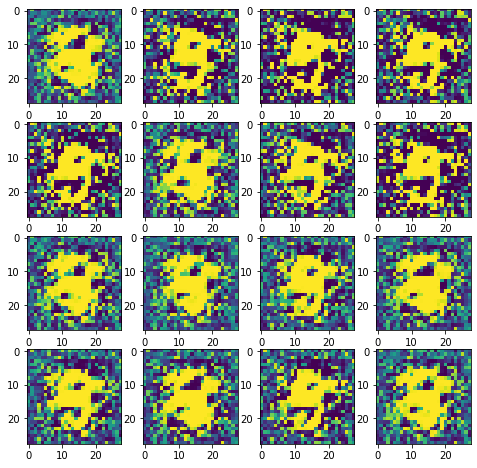

In [0]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = test[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()